In [1]:
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim,Optim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO, CSV, DataFrames, Statistics

### Effect of glutamine deprivation WITHOUT treatment

In [ ]:
###OVCAR3 naive, using r and k from 0cis and gln+ and fitting to 0cis and gln- data 

In [22]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(0.0,0.0)) #for 0 cis and gln-
    N = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaN, betaN, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
      
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    #growth_P = 0.0345735478962347 * P * (1 - (P + gammaP * N)/ 6.15404191932215)
    
    #PARP inhibitor effect 
    parp_N = alphaN * PARP_effect * N
    #parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = betaN * (1 - GLN_effect) * N
    #gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N  
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [35]:
#import data for 0cis and gln- so we can fit that curve to it 
OVCAR3_N_NOglu="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_S_Glu-_0cis_avg_norm.csv"
OVCAR3_N_NOglu=CSV.read(OVCAR3_N_NOglu,DataFrame)
data_naive_NOglu_NOdrug=Matrix(OVCAR3_N_NOglu)

OVCAR3_P_NOglu="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_R_Glu-_0cis_avg_norm.csv"
OVCAR3_P_NOglu=CSV.read(OVCAR3_P_NOglu,DataFrame)
data_persis_NOglu_Nodrug=Matrix(OVCAR3_P_NOglu)

1×8 Matrix{Float64}:
 1.0  1.68837  2.34585  2.56742  2.61543  2.78426  2.85829  2.87809

In [36]:
timepts = [0.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0]

8-element Vector{Float64}:
   0.0
  24.0
  48.0
  72.0
  96.0
 120.0
 144.0
 168.0

In [57]:
t= collect(range(0, stop=168, length = 8))

8-element Vector{Float64}:
   0.0
  24.0
  48.0
  72.0
  96.0
 120.0
 144.0
 168.0

In [53]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.2,0.01, 0.0, 0.0]

4-element Vector{Float64}:
 0.2
 0.01
 0.0
 0.0

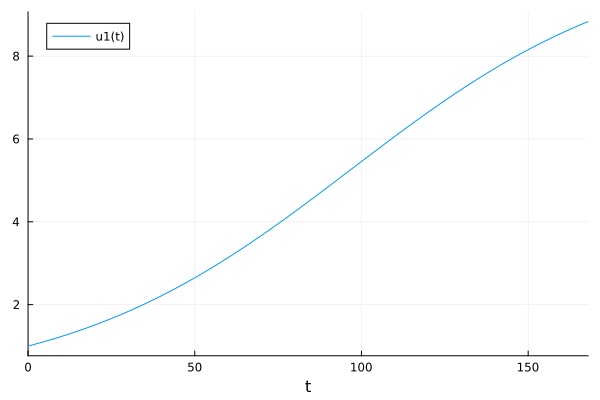

In [54]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

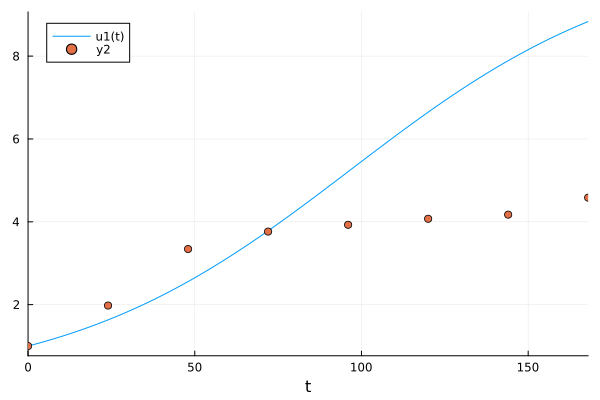

In [55]:
scatter!(timepts,data_naive_NOglu_NOdrug[1,:])

In [58]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_naive_NOglu_NOdrug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [59]:
optprob = Optimization.OptimizationProblem(cost_function, [0.2,0.01, 0.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.2
 0.016765061609800073
 0.0
 0.0

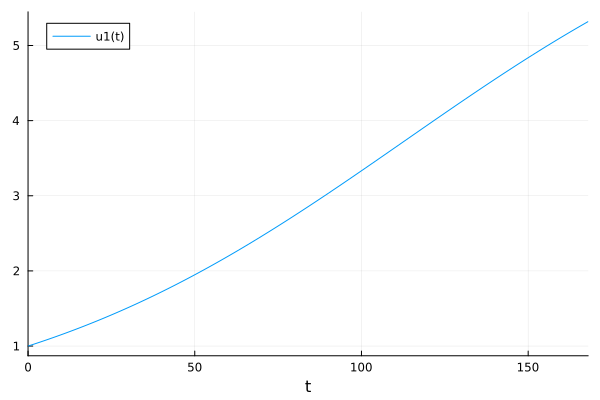

In [60]:
newprob_NOglu_NOdrug = remake(prob, p=optsol)
newsol_NOglu_NOdrug = solve(newprob_NOglu_NOdrug, Tsit5(), saveat=1)
plot(newsol_NOglu_NOdrug)

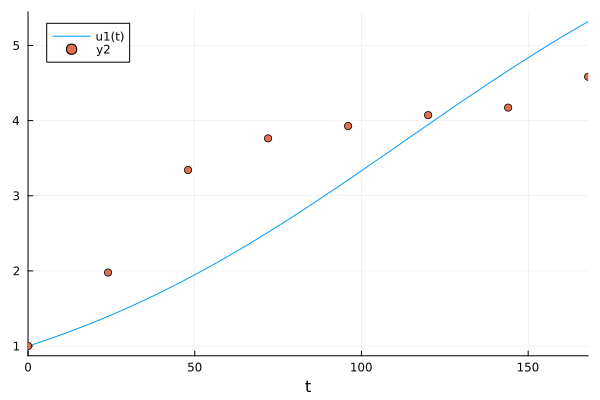

In [61]:
scatter!(timepts,data_naive_NOglu_NOdrug[1,:])

In [ ]:
####OVCAR3 persistent, using r and k from 0cis and gln+ and fitting to 0cis and gln- data 

In [62]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(0.0,0.0)) #for 0 cis and gln-
    P = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaP, betaP, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    #growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    growth_P = 0.0345735478962347 * P * (1 - (P / 6.15404191932215))#growth rate and carrying capacity for 0cis and gln+
    
    #PARP inhibitor effect 
    #parp_N = alphaN * PARP_effect * N
    parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    #gln_N = betaN * (1 - GLN_effect) * N
    gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_P - parp_P - gln_P 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [75]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.2,0.015, 0.0, 0.0]

4-element Vector{Float64}:
 0.2
 0.015
 0.0
 0.0

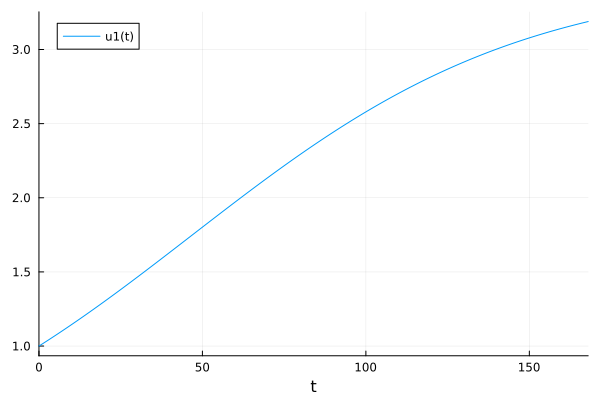

In [76]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

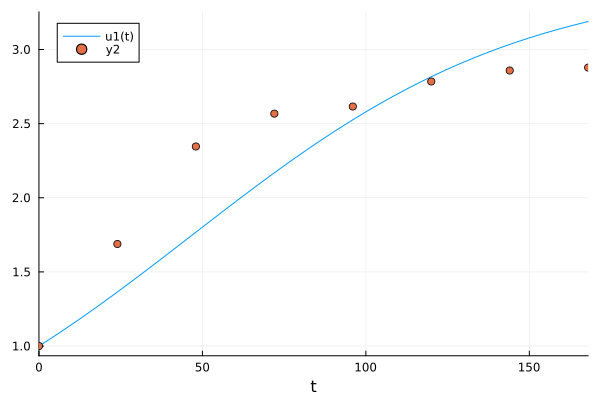

In [77]:
scatter!(timepts,data_persis_NOglu_Nodrug[1,:])

In [78]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_persis_NOglu_Nodrug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [79]:
optprob = Optimization.OptimizationProblem(cost_function, [0.2,0.015, 0.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.2
 0.01491779368926134
 0.0
 0.0

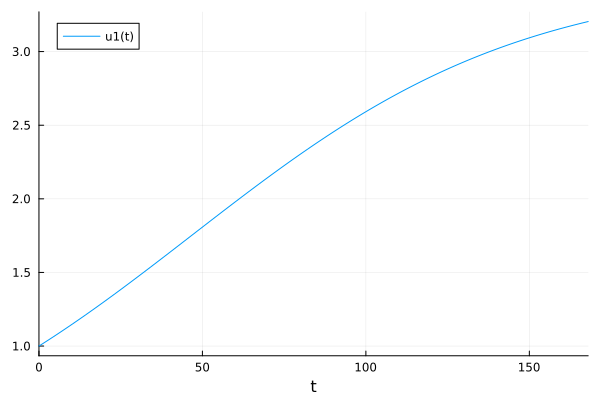

In [80]:
newprob_NOglu_NOdrug = remake(prob, p=optsol)
newsol_NOglu_NOdrug = solve(newprob_NOglu_NOdrug, Tsit5(), saveat=1)
plot(newsol_NOglu_NOdrug)

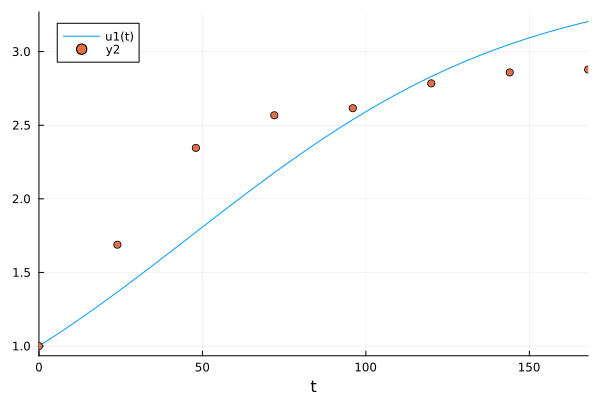

In [81]:
scatter!(timepts,data_persis_NOglu_Nodrug[1,:])

In [82]:
### co-culture simulation 0cis gln- (0.0,0.0)

In [406]:
function cancer_model_coculture_0cis_NOgln!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(0.0,0.0))
    N, P = u #these are the only two populations we are trying to model 
    #tried without death term 
    alphaN, alphaP, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N + P)/15.0361586740725)
    growth_P = 0.0345735478962347 * P * (1 - (N + P)/ 6.15404191932215)
    
    #PARP inhibitor effect 
    parp_N = alphaN * PARP_effect * N
    parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = 0.016765062 * (1 - GLN_effect) * N 
    gln_P = 0.014917794 * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N
    du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model_coculture_0cis_NOgln! (generic function with 1 method)

In [414]:
u0=[0.25,0.75]
tspan=(0.0,168.0)
p=[0.02,0.001, 0.0, 0.0]

4-element Vector{Float64}:
 0.02
 0.001
 0.0
 0.0

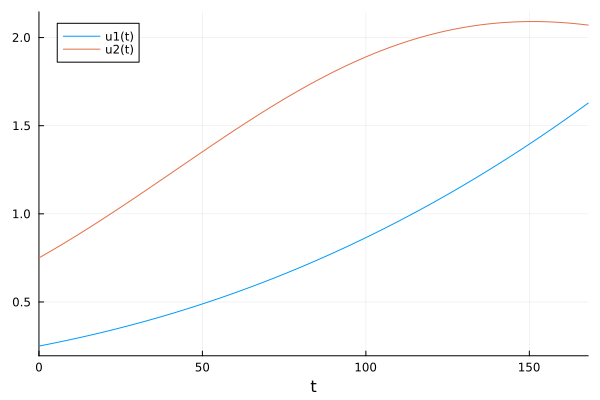

In [415]:
prob_0cis_NOgln=ODEProblem(cancer_model_coculture_0cis_NOgln!,u0,tspan,p)

sol_0cis_NOgln=solve(prob_0cis_NOgln,Tsit5(), saveat=1)

plot(sol_0cis_NOgln)

In [409]:
sol_0cis_NOgln

retcode: Success
Interpolation: 1st order linear
t: 169-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
   ⋮
 157.0
 158.0
 159.0
 160.0
 161.0
 162.0
 163.0
 164.0
 165.0
 166.0
 167.0
 168.0
u: 169-element Vector{Vector{Float64}}:
 [0.5, 0.5]
 [0.5071945441333053, 0.5070481095597149]
 [0.5144763096912681, 0.5141542190583305]
 [0.5218459160830808, 0.5213175650621794]
 [0.5293039745675353, 0.5285373419341727]
 [0.5368510938660255, 0.5358127040012288]
 [0.5444878752461264, 0.543142762281399]
 [0.5522149114900178, 0.5505265839257633]
 [0.5600327868944838, 0.55796319221843]
 [0.5679420772709131, 0.565451566576537]
 [0.5759433499452984, 0.5729906425502502]
 [0.584037163758238, 0.5805793118227652]
 [0.592224069064934, 0.5882164222103061]
 ⋮
 [2.81769898852467, 1.221486995197374]
 [2.83906989783791, 1.2177234872332854]
 [2.860491583001867, 1.2138516447319696]
 [2.881963120162565, 1.2098729561133184]
 [2.9034835779335237, 1.2

In [416]:
CSV.write("Predicted_Co-culture_25-75_OVCAR3__Glu-_0cis_norm.csv",sol_0cis_NOgln)

"Predicted_Co-culture_25-75_OVCAR3__Glu-_0cis_norm.csv"

### Effect of PARP treatment WITH glutamine

In [ ]:
###OVCAR3 naive, using r and k from 0cis and gln+ and fitting to 50cis and gln+ data 

In [120]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,1.0)) #for 50 cis and gln+
    N = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaN, betaN, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    #growth_P = 0.0345735478962347 * P * (1 - (P + gammaP * N)/ 6.15404191932215)
    
    #PARP inhibitor effect 
    parp_N = alphaN * PARP_effect * N
    #parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = betaN * (1 - GLN_effect) * N
    #gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [121]:
#data for 50cis and glu+
OVCAR3_N_glu_drug="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_S_Glu+_50cis_avg_norm.csv"
OVCAR3_N_glu_drug=CSV.read(OVCAR3_N_glu_drug,DataFrame)
data_naive_glu_drug=Matrix(OVCAR3_N_glu_drug)

OVCAR3_P_glu_drug="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_R_Glu+_50cis_avg_norm.csv"
OVCAR3_P_glu_drug=CSV.read(OVCAR3_P_glu_drug, DataFrame)
data_persis_glu_drug=Matrix(OVCAR3_P_glu_drug)

1×8 Matrix{Float64}:
 1.0  1.71095  2.49961  3.26738  3.99632  4.75726  5.17432  5.30182

In [127]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.01,0.015, 1.0, 1.0]

4-element Vector{Float64}:
 0.01
 0.015
 1.0
 1.0

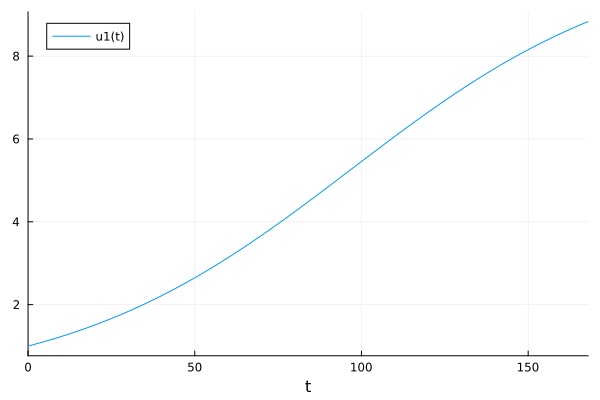

In [128]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

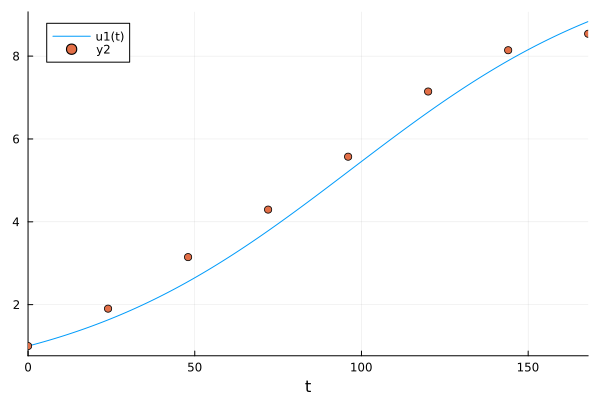

In [129]:
scatter!(timepts, data_naive_glu_drug[1,:])

In [130]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_naive_glu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [131]:
optprob = Optimization.OptimizationProblem(cost_function, [0.01,0.015, 1.0, 1.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.009469775637127226
 0.015
 1.0
 1.0

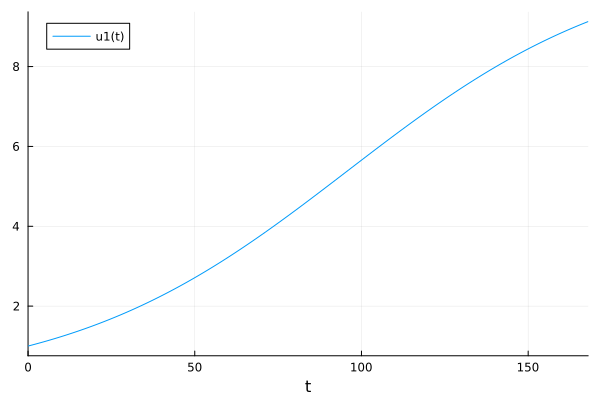

In [132]:
newprob_glu_drug = remake(prob, p=optsol)
newsol_glu_drug = solve(newprob_glu_drug, Tsit5(), saveat=1)
plot(newsol_glu_drug)

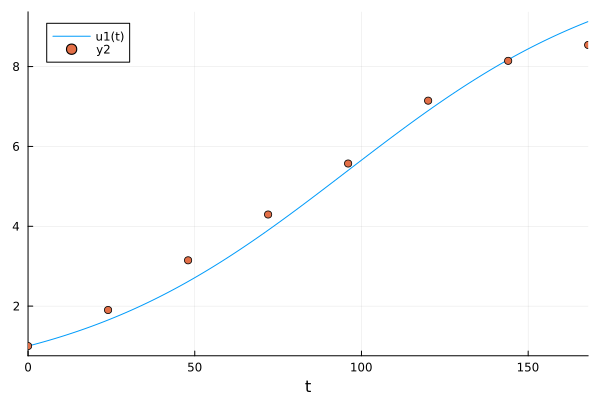

In [133]:
scatter!(timepts, data_naive_glu_drug[1,:])

In [134]:
###OVCAR3 persistent, using r and k from 0cis and gln+ and fitting to 50cis and gln+ data 
    ##this value should be super close to 0 

In [135]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,1.0)) #for 50 cis and gln+
    P = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaP, betaP, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    #growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    growth_P = 0.0345735478962347 * P * (1 - (P / 6.15404191932215))#growth rate and carrying capacity for 0cis and gln+
    
    #PARP inhibitor effect 
    #parp_N = alphaN * PARP_effect * N
    parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    #gln_N = betaN * (1 - GLN_effect) * N
    gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_P - parp_P - gln_P 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [139]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.001,0.00015, 1.0, 1.0]

4-element Vector{Float64}:
 0.001
 0.00015
 1.0
 1.0

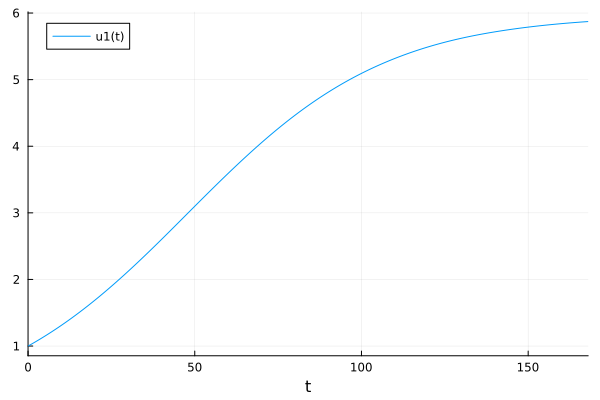

In [140]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

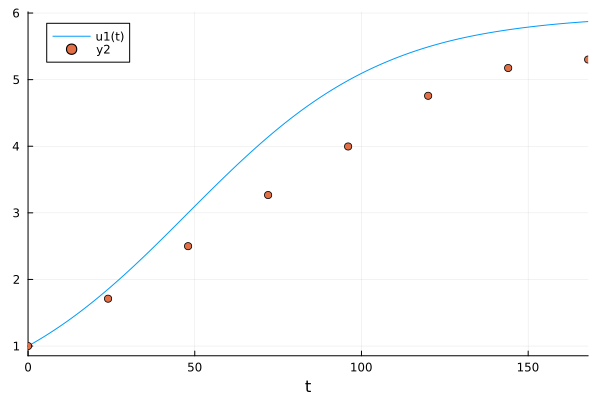

In [141]:
scatter!(timepts, data_persis_glu_drug[1,:])

In [142]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_persis_glu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [143]:
optprob = Optimization.OptimizationProblem(cost_function, [0.001,0.015, 1.0, 1.0])
optsol = solve(optprob, BFGS())
#pretty close to 0, PARP barely affected it 

retcode: Success
u: 4-element Vector{Float64}:
 0.0049616370448382265
 0.015
 1.0
 1.0

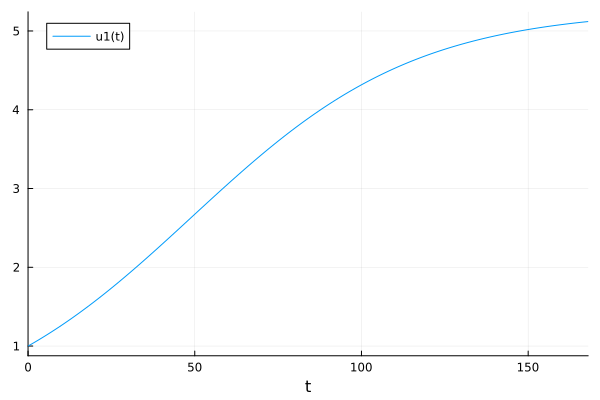

In [144]:
newprob_glu_drug = remake(prob, p=optsol)
newsol_glu_drug = solve(newprob_glu_drug, Tsit5(), saveat=1)
plot(newsol_glu_drug)

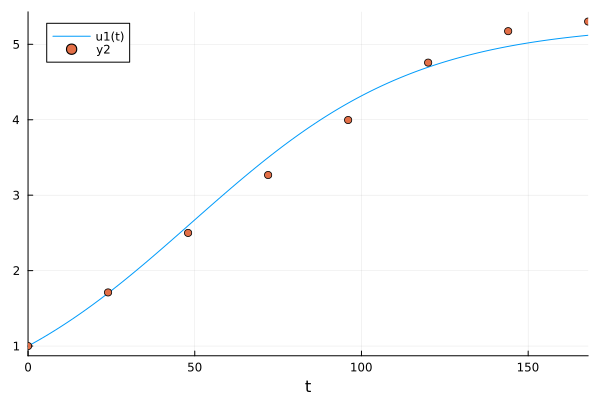

In [145]:
scatter!(timepts, data_persis_glu_drug[1,:])

In [ ]:
### co-culture simulation 50cis gln+ (1.0,1.0)

In [417]:
function cancer_model_coculture_50cis_gln!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,1.0))
    N, P = u #these are the only two populations we are trying to model 
    #tried without death term 
    PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N + P)/15.0361586740725)
    growth_P = 0.0345735478962347 * P * (1 - (N + P)/ 6.15404191932215)
    
    #PARP inhibitor effect 
    parp_N = 0.009469776 * PARP_effect * N
    parp_P = 0.004961637 * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = 0.016765062 * (1 - GLN_effect) * N 
    gln_P = 0.014917794 * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N
    du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model_coculture_50cis_gln! (generic function with 1 method)

In [427]:
u0=[0.1,0.9]
tspan=(0.0,168.0)
p=[1.0, 1.0]

2-element Vector{Float64}:
 1.0
 1.0

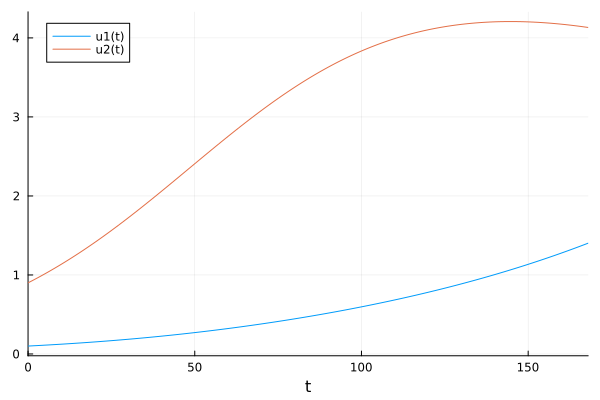

In [428]:
prob_50cis_gln=ODEProblem(cancer_model_coculture_50cis_gln!,u0,tspan,p)

sol_50cis_gln=solve(prob_50cis_gln,Tsit5(), saveat=1)

plot(sol_50cis_gln)

In [426]:
CSV.write("Predicted_Co-culture_25-75_OVCAR3__Glu+_50cis_norm.csv",sol_50cis_gln)

"Predicted_Co-culture_25-75_OVCAR3__Glu+_50cis_norm.csv"

### Effect of PARP and glutamine deprivation

In [ ]:
###OVCAR3 naive, using r and k from 0cis and gln+ and fitting to 50cis and gln- data and get 2 new beta and alpha

In [331]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0)) #for 50 cis and gln-
    N = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaN, betaN, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    #growth_P = 0.0345735478962347 * P * (1 - (P + gammaP * N)/ 6.15404191932215)
    
    #PARP inhibitor effect 
    parp_N = alphaN * PARP_effect * N
    #parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = betaN * (1 - GLN_effect) * N
    #gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [171]:
OVCAR3_N_NOglu_drug="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_S_Glu-_50cis_avg_norm.csv"
OVCAR3_N_NOglu_drug=CSV.read(OVCAR3_N_NOglu_drug,DataFrame)
data_naive_NOglu_drug=Matrix(OVCAR3_N_NOglu_drug)

OVCAR3_P_NOglu_drug="/blue/ferrallm/adelpinoherrera/Ovarian-scRNA-sequencing/OVCAR3_R_Glu-_50cis_avg_norm.csv"
OVCAR3_P_NOglu_drug=CSV.read(OVCAR3_P_NOglu_drug,DataFrame)
data_persis_NOglu_drug=Matrix(OVCAR3_P_NOglu_drug)

1×8 Matrix{Float64}:
 1.0  1.49956  1.91398  2.20001  2.34654  2.67418  2.8721  2.96834

In [332]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.009,0.016, 1.0, 0.0]

4-element Vector{Float64}:
 0.009
 0.016
 1.0
 0.0

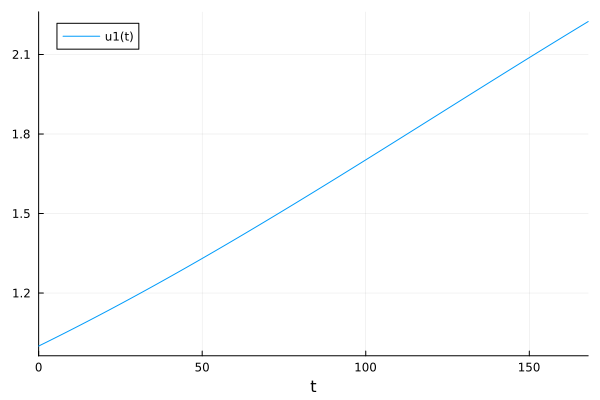

In [333]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

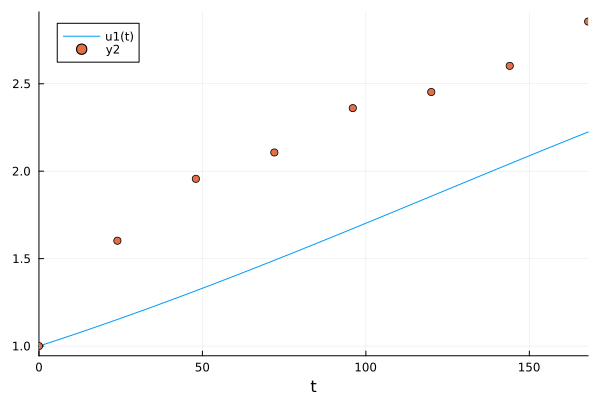

In [334]:
scatter!(timepts, data_naive_NOglu_drug[1,:])

In [335]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_naive_NOglu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [336]:
optprob = Optimization.OptimizationProblem(cost_function, [0.009,0.016, 1.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.007595918070174391
 0.014595918073412876
 1.0
 0.0

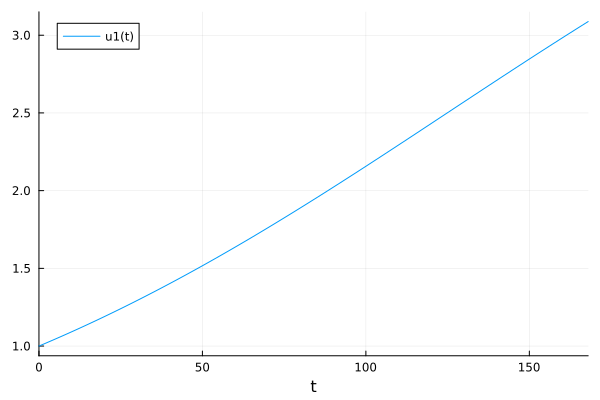

In [337]:
newprob_NOglu_drug = remake(prob, p=optsol)
newsol_NOglu_drug = solve(newprob_NOglu_drug, Tsit5(), saveat=1)
plot(newsol_NOglu_drug)

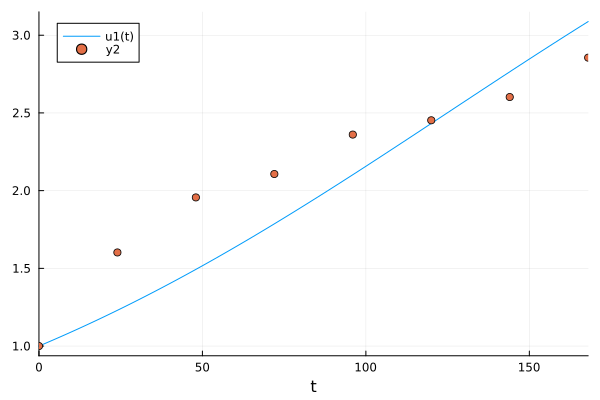

In [338]:
scatter!(timepts, data_naive_NOglu_drug[1,:])

In [227]:
### TRY with changing a factor
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0)) #for 50 cis and gln-
    N = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    factor_alphaN, factor_betaN, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    #growth_P = 0.0345735478962347 * P * (1 - (P + gammaP * N)/ 6.15404191932215)
    
    #death terms (may add later)
    #death_N = dN * N
    
    #PARP inhibitor effect 
    parp_N = 0.009469776 * PARP_effect * N #use alpha previously calculated 
    #parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = 0.016765062 * (1 - GLN_effect) * N #use beta previously calculated
    #gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_N - factor_alphaN * parp_N - factor_betaN * gln_N  #maybe add death term - death_N 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [228]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.9,0.8, 1.0, 0.0]

4-element Vector{Float64}:
 0.9
 0.8
 1.0
 0.0

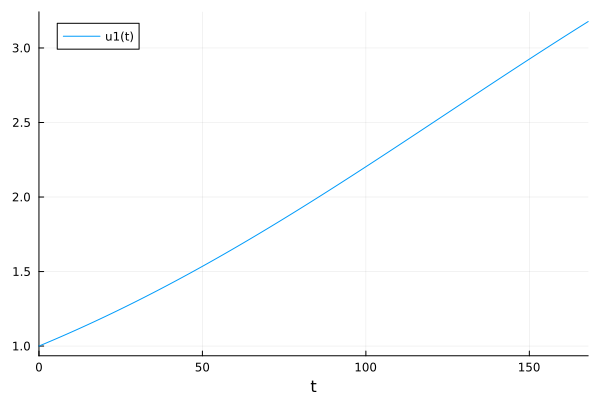

In [229]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

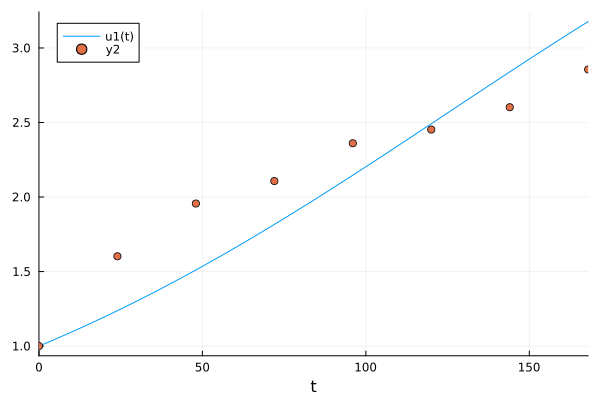

In [230]:
scatter!(timepts, data_naive_NOglu_drug[1,:])

In [231]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_naive_NOglu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [232]:
optprob = Optimization.OptimizationProblem(cost_function, [0.9,0.8, 1.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.9065641682708778
 0.8116210444724037
 1.0
 0.0

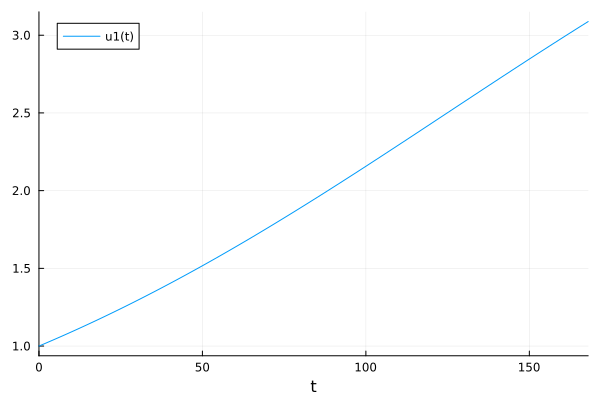

In [234]:
newprob_NOglu_drug = remake(prob, p=optsol)
newsol_NOglu_drug = solve(newprob_NOglu_drug, Tsit5(), saveat=1)
plot(newsol_NOglu_drug)

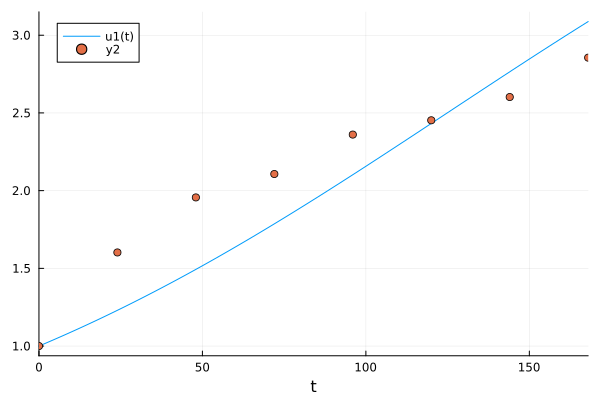

In [235]:
scatter!(timepts, data_naive_NOglu_drug[1,:])

In [236]:
###OVCAR3 persistent, using r and k from 0cis and gln+ and fitting to 50cis and gln- data and get 2 new beta and alpha

In [274]:
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0)) #for 50 cis and gln-
    P = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    alphaP, betaP, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    
    #growth terms 
    #growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    growth_P = 0.0345735478962347 * P * (1 - (P/ 6.15404191932215))
    
    #death terms (may add later)
    #death_N = dN * N
    
    #PARP inhibitor effect 
    #parp_N = alphaN * PARP_effect * N
    parp_P = alphaP * PARP_effect * P 
    
    #glutamine deprivation effect
    #gln_N = betaN * (1 - GLN_effect) * N
    gln_P = betaP * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_P - parp_P - gln_P  #maybe add death term - death_N 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [275]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.004,0.01, 1.0, 0.0]

4-element Vector{Float64}:
 0.004
 0.01
 1.0
 0.0

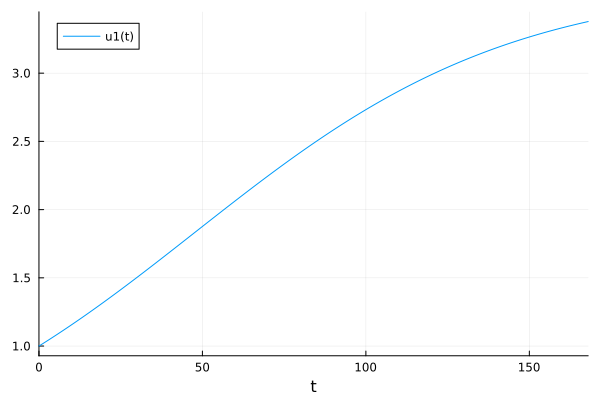

In [276]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

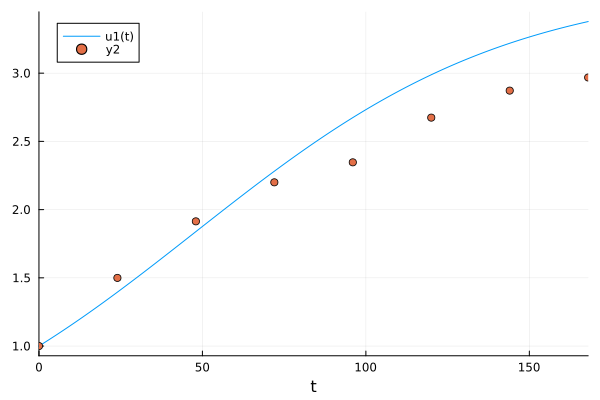

In [261]:
scatter!(timepts, data_persis_NOglu_drug[1,:])

In [277]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_persis_NOglu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [278]:
optprob = Optimization.OptimizationProblem(cost_function, [0.004,0.01, 1.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.004881685421766963
 0.010881685421755256
 1.0
 0.0

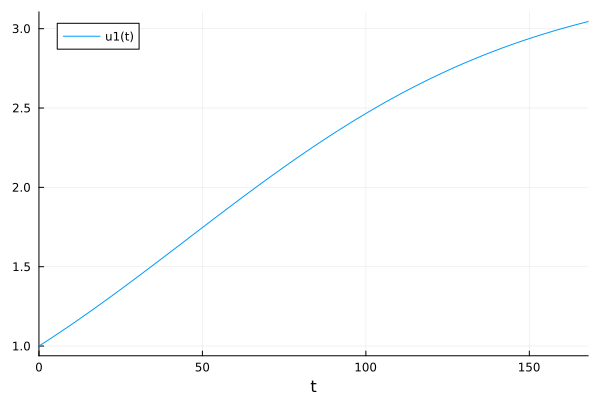

In [279]:
newprob_NOglu_drug = remake(prob, p=optsol)
newsol_NOglu_drug = solve(newprob_NOglu_drug, Tsit5(), saveat=1)
plot(newsol_NOglu_drug)

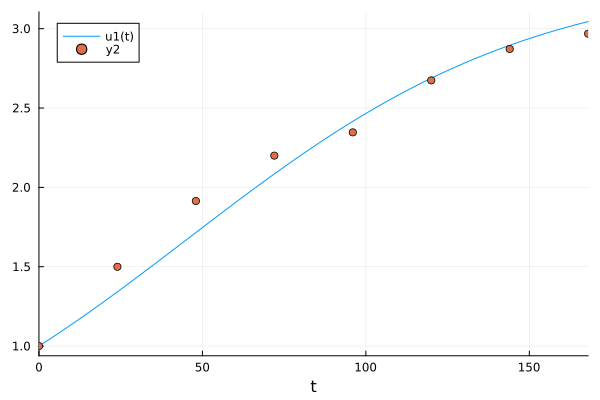

In [280]:
scatter!(timepts, data_persis_NOglu_drug[1,:])

In [281]:
### TRY with changing a factor
function cancer_model!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0)) #for 50 cis and gln-
    P = u[1] #these are the only two populations we are trying to model 
    #tried without death term 
    factor_alphaP, factor_betaP, PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    
    #growth terms 
    #growth_N = 0.033280724664674 * N * (1 - (N /15.0361586740725)) #growth rate and carrying capacity for 0cis and gln+
    growth_P = 0.0345735478962347 * P * (1 - (P / 6.15404191932215))
    
    #death terms (may add later)
    #death_N = dN * N
    
    #PARP inhibitor effect 
    #parp_N = 0.009469776 * PARP_effect * N #use alpha previously calculated 
    parp_P = 0.004961637 * PARP_effect * P 
    
    #glutamine deprivation effect
    #gln_N = 0.016765062 * (1 - GLN_effect) * N #use beta previously calculated
    gln_P = 0.014917794 * (1 - GLN_effect) * P 
    
    #put the terms togther 
    du[1] = growth_P - factor_alphaP * parp_P - factor_betaP * gln_P  #maybe add death term - death_N 
    #du[2] = growth_P - parp_P - gln_P
    
end 

cancer_model! (generic function with 1 method)

In [282]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.98,0.73, 1.0, 0.0]

4-element Vector{Float64}:
 0.98
 0.73
 1.0
 0.0

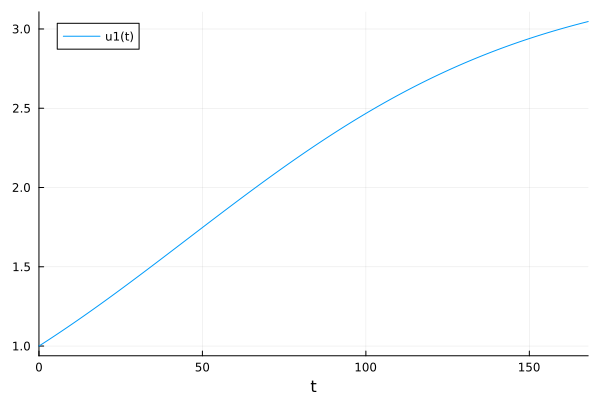

In [283]:
prob=ODEProblem(cancer_model!,u0,tspan,p)

sol=solve(prob,Tsit5())

plot(sol)

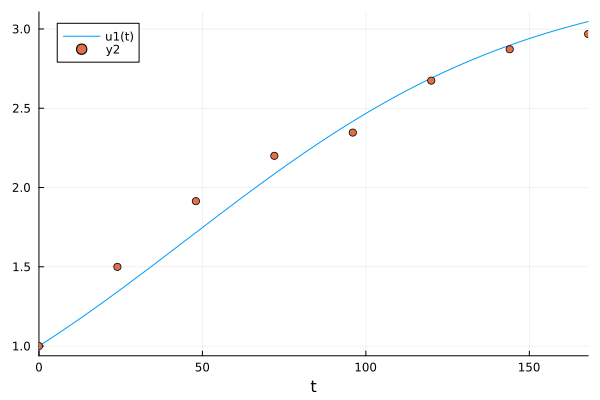

In [284]:
scatter!(timepts, data_persis_NOglu_drug[1,:])

In [285]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data_persis_NOglu_drug),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(cancer_model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothi

In [288]:
optprob = Optimization.OptimizationProblem(cost_function, [0.9,0.7, 1.0, 0.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 0.917172999926556
 0.7516328129741005
 1.0
 0.0

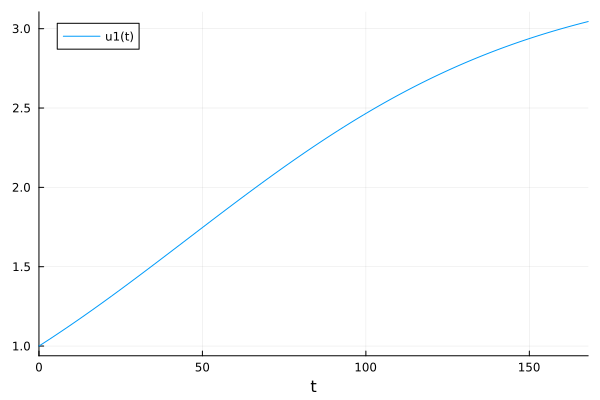

In [289]:
newprob_NOglu_drug = remake(prob, p=optsol)
newsol_NOglu_drug = solve(newprob_NOglu_drug, Tsit5(), saveat=1)
plot(newsol_NOglu_drug)

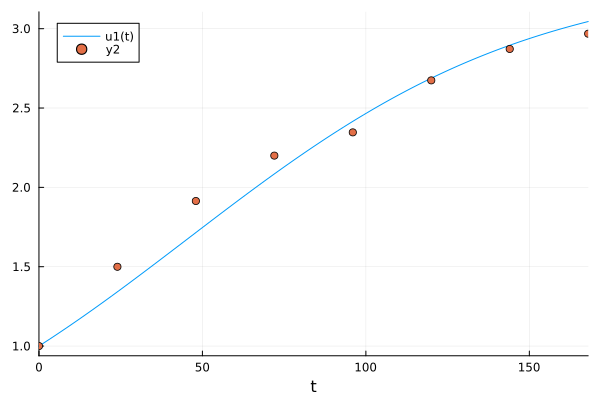

In [290]:
scatter!(timepts, data_persis_NOglu_drug[1,:])

In [306]:
#co-culture 50cis and gln- 
function cancer_model_coculture_50cis_NOgln!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0))
    N, P = u #these are the only two populations we are trying to model 
    #tried without death term 
    PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N + P)/15.0361586740725)
    growth_P = 0.0345735478962347 * P * (1 - (N + P)/ 6.15404191932215)
    
    #death terms (may add later)
    
    #PARP inhibitor effect 
    parp_N = 0.009469776 * PARP_effect * N
    parp_P = 0.004961637 * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = 0.016765062 * (1 - GLN_effect) * N 
    gln_P = 0.014917794 * (1 - GLN_effect) * P 
    
    #factor when combination of drugs happens
    factor_alphaN =  0.906564168
    factor_betaN =  0.811621044
    
    factor_alphaP = 0.917173
    factor_betaP = 0.751632813

    #put the terms togther 
    du[1] = growth_N - factor_alphaN * parp_N - factor_betaN * gln_N
    du[2] = growth_P - factor_alphaP * parp_P - factor_betaP * gln_P

end 

cancer_model_coculture_50cis_NOgln! (generic function with 1 method)

In [325]:
u0=[0.1875,0.0625]
tspan=(0.0,336.0)
p=[1.0, 0.0]

2-element Vector{Float64}:
 1.0
 0.0

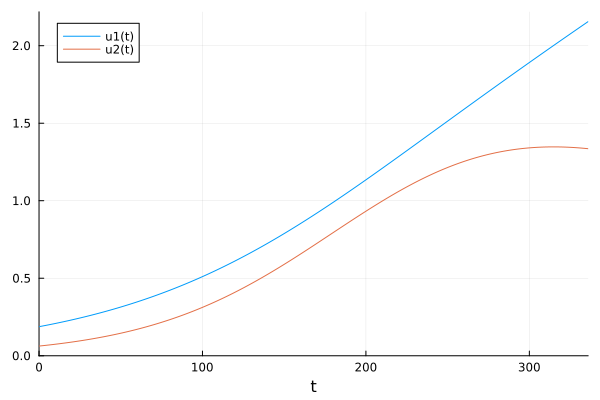

In [326]:
prob_50cis_NOgln=ODEProblem(cancer_model_coculture_50cis_NOgln!,u0,tspan,p)

sol_50cis_NOgln=solve(prob_50cis_NOgln,Tsit5())

plot(sol_50cis_NOgln)

In [321]:
sol_50cis_NOgln

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 11-element Vector{Float64}:
   0.0
   0.24546952877556139
   2.700164816531175
  20.019501475453456
  53.17983204669993
  95.28463973797203
 138.5466427618312
 194.69462396403827
 256.83865735049426
 318.65443143529234
 336.0
u: 11-element Vector{Vector{Float64}}:
 [0.5, 0.5]
 [0.5010901520336873, 0.5016208214975504]
 [0.5120815054382379, 0.5180136290669181]
 [0.5941658316021261, 0.6427011505899568]
 [0.7712093982931908, 0.9142207151509291]
 [1.022217978855982, 1.2616612095087771]
 [1.2922061552918251, 1.527208582064426]
 [1.6422067840520962, 1.661369676321002]
 [2.028244409372575, 1.589443766706319]
 [2.419081348146342, 1.3959393849566506]
 [2.530378814187405, 1.330833001468167]

In [320]:
N_sol = sol_50cis_NOgln[1,:]
P_sol = sol_50cis_NOgln[2,:]

11-element Vector{Float64}:
 0.5
 0.5016208214975504
 0.5180136290669181
 0.6427011505899568
 0.9142207151509291
 1.2616612095087771
 1.527208582064426
 1.661369676321002
 1.589443766706319
 1.3959393849566506
 1.330833001468167

In [322]:
total_sol = N_sol + P_sol

11-element Vector{Float64}:
 1.0
 1.0027109735312378
 1.030095134505156
 1.2368669821920828
 1.6854301134441199
 2.283879188364759
 2.819414737356251
 3.3035764603730984
 3.617688176078894
 3.815020733102992
 3.861211815655572

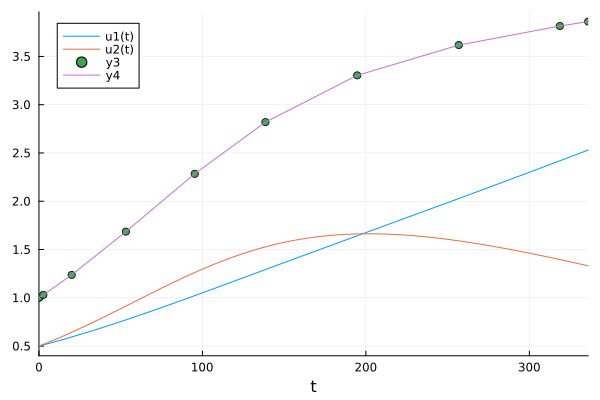

In [324]:
plot!(sol_50cis_NOgln.t, total_sol)

In [314]:
sol_50cis_NOgln.u

11-element Vector{Vector{Float64}}:
 [0.5, 0.5]
 [0.5010901520336873, 0.5016208214975504]
 [0.5120815054382379, 0.5180136290669181]
 [0.5941658316021261, 0.6427011505899568]
 [0.7712093982931908, 0.9142207151509291]
 [1.022217978855982, 1.2616612095087771]
 [1.2922061552918251, 1.527208582064426]
 [1.6422067840520962, 1.661369676321002]
 [2.028244409372575, 1.589443766706319]
 [2.419081348146342, 1.3959393849566506]
 [2.530378814187405, 1.330833001468167]

In [311]:
N_sol = sol_50cis_NOgln[:,1]

2-element Vector{Float64}:
 0.5
 0.5

In [382]:
#co-culture without the factors 
#co-culture 50cis and gln- 
function cancer_model_coculture_50cis_NOgln!(du,u,p,t; fixed_PARPGLN=true, fixed_values=(1.0,0.0))
    N, P = u #these are the only two populations we are trying to model 
    #tried without death term 
    PARP, GLN = p 
    #alpha terms are the parp inhibitor effect
    #beta terms are the glutamine effect
    #PARP is the PARP parameter that we will change between 0 and 1
    #Gln is the Gln parameter that we will change between 0 and 1
    
    #If fixed_PARPGLN is true, use the fixed values, otherwise use parameters
    PARP_effect = fixed_PARPGLN ? fixed_values[1] : PARP
    GLN_effect = fixed_PARPGLN ? fixed_values[2] : GLN
    
    
    #growth terms 
    growth_N = 0.033280724664674 * N * (1 - (N + P)/15.0361586740725)
    growth_P = 0.0345735478962347 * P * (1 - (N + P)/ 6.15404191932215)
    
    #death terms (may add later)
    
    #PARP inhibitor effect 
    parp_N = 0.007595918 * PARP_effect * N
    parp_P = 0.004881685 * PARP_effect * P 
    
    #glutamine deprivation effect
    gln_N = 0.014595918 * (1 - GLN_effect) * N 
    gln_P = 0.010881685 * (1 - GLN_effect) * P 
    
    
    #put the terms togther 
    du[1] = growth_N - parp_N - gln_N
    du[2] = growth_P - parp_P - gln_P

end 

cancer_model_coculture_50cis_NOgln! (generic function with 1 method)

In [387]:
u0=[0.25,0.75]
tspan=(0.0,168.0)
p=[1.0, 0.0]

2-element Vector{Float64}:
 1.0
 0.0

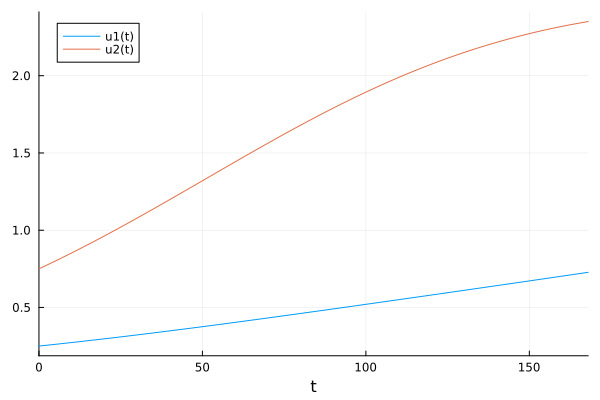

In [388]:
prob_50cis_NOgln=ODEProblem(cancer_model_coculture_50cis_NOgln!,u0,tspan,p)

sol_50cis_NOgln=solve(prob_50cis_NOgln,Tsit5(),saveat=1)

plot(sol_50cis_NOgln)

In [390]:
sol_50cis_NOgln

retcode: Success
Interpolation: 1st order linear
t: 169-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
   ⋮
 157.0
 158.0
 159.0
 160.0
 161.0
 162.0
 163.0
 164.0
 165.0
 166.0
 167.0
 168.0
u: 169-element Vector{Vector{Float64}}:
 [0.25, 0.75]
 [0.252225363559524, 0.759933743337995]
 [0.25446366182549646, 0.7699462634391069]
 [0.25671483630538805, 0.7800368166415503]
 [0.25897882688795254, 0.7902046293911915]
 [0.2612555697589275, 0.8004488797688702]
 [0.26354499835787826, 0.8107687043335083]
 [0.2658470438637526, 0.8211632022205589]
 [0.2681616351948805, 0.8316314351420064]
 [0.2704886990089744, 0.8421724273863667]
 [0.272828159703129, 0.8527851658186868]
 [0.2751799394138215, 0.8634685998805453]
 [0.2775439580169113, 0.8742216415900519]
 ⋮
 [0.6933264733483107, 2.306386550131026]
 [0.6964123911389087, 2.3108571433563325]
 [0.6995004110638184, 2.3152386725398353]
 [0.7025905739733992, 2.3195317222793386]
 [0.705682

In [391]:
CSV.write("Predicted_Co-culture_25-75_OVCAR3__Glu-_50cis_norm.csv",sol_50cis_NOgln)

"Predicted_Co-culture_25-75_OVCAR3__Glu-_50cis_norm.csv"

In [381]:
N_sol = sol_50cis_NOgln[1,:]
P_sol = sol_50cis_NOgln[2,:]
total = N_sol + P_sol 

169-element Vector{Float64}:
 1.0
 1.0099906920679151
 1.0200533416128583
 1.0301878083122296
 1.04039393366424
 1.0506715460455882
 1.0610204573144277
 1.0714404614823514
 1.081931334714392
 1.0924928353290224
 1.103124703798155
 1.1138266627471425
 1.124598416954776
 ⋮
 2.990649057058591
 3.001922070500787
 3.0131341075563274
 3.0242849234652796
 3.035374290997782
 3.046402000454045
 3.057367859664348
 3.0682716939890455
 3.0791133463185645
 3.089892677073398
 3.100609564204115
 3.1112639031913565